In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

In [63]:
df = pd.DataFrame()

In [137]:
# Random toy data
df['X1'] = [1,2,3,4,5,6,6,7,9,9]
df['X2'] = [5,3,6,8,1,9,5,8,9,2]
df['label'] = [1,1,0,1,0,1,0,1,0,0]

In [65]:
df

,X1,X2,label
0,1,5,1
1,2,3,1
2,3,6,0
3,4,8,1
4,5,1,0
5,6,9,1
6,6,5,0
7,7,8,1
8,9,9,0
9,9,2,0


In [139]:
# weight = 1/n, where n=total no. of rows
df['weight'] = 1/df.shape[0]

<Axes: xlabel='X1', ylabel='X2'>

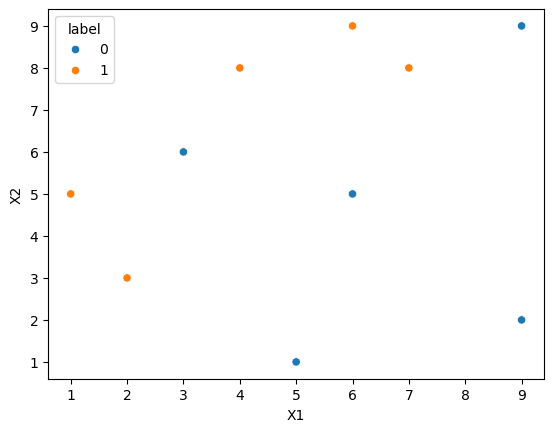

In [67]:
sns.scatterplot(x=df['X1'], y=df["X2"], hue=df['label'])

In [68]:
X = df.iloc[:, 0:2].values
y = df.iloc[:, -2].values

In [69]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(X, y)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'x[0] <= 2.5\ngini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.75, 0.25, 'gini = 0.469\nsamples = 8\nvalue = [5, 3]')]

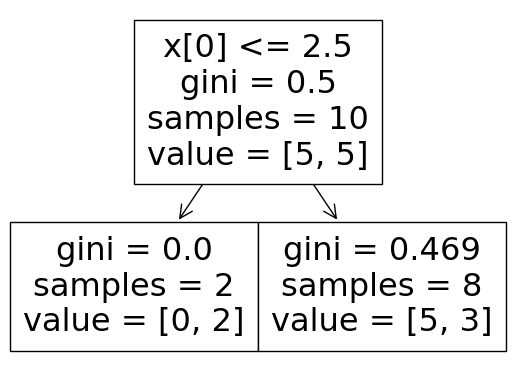

In [70]:
plot_tree(dt1)

In [71]:
df['y_pred'] = dt1.predict(X)

In [72]:
df

,X1,X2,label,weight,y_pred
0,1,5,1,0.1,1
1,2,3,1,0.1,1
2,3,6,0,0.1,0
3,4,8,1,0.1,0
4,5,1,0,0.1,0
5,6,9,1,0.1,0
6,6,5,0,0.1,0
7,7,8,1,0.1,0
8,9,9,0,0.1,0
9,9,2,0,0.1,0


<Axes: >

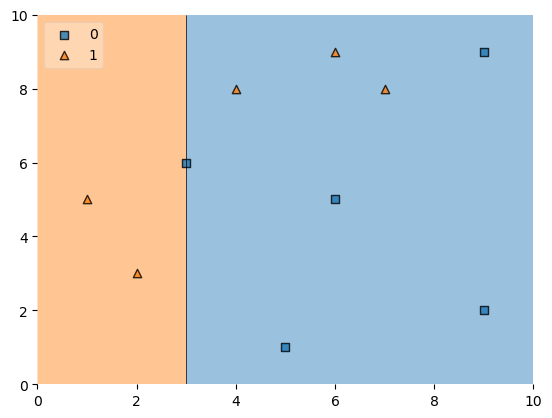

In [87]:
plot_decision_regions(X, y, clf=dt1, legend=2)

In [95]:
# Calculate the error of the model
def calculate_model_weight(error):
    return 0.5 * np.log((1-error)/error)

In [99]:
# return the error of this model
alpha1 = calculate_model_weight(0.3)
print(alpha1)

0.42364893019360184


In [121]:
# Update and Boost the misclassified data, we use exponential function for some reasons
def update_row_weights(row, alpha=0.4236):
    if row['label'] == row['y_pred']:
        return row['weight'] * np.exp(-alpha)
    else:
        return row['weight'] * np.exp(alpha)

In [123]:
# apply the changes to all rows
df['updated_weights'] = df.apply(update_row_weights, axis=1)

In [125]:
df

,X1,X2,label,weight,y_pred,updated_weights
0,1,5,1,0.1,1,0.065469
1,2,3,1,0.1,1,0.065469
2,3,6,0,0.1,0,0.065469
3,4,8,1,0.1,0,0.152745
4,5,1,0,0.1,0,0.065469
5,6,9,1,0.1,0,0.152745
6,6,5,0,0.1,0,0.065469
7,7,8,1,0.1,0,0.152745
8,9,9,0,0.1,0,0.065469
9,9,2,0,0.1,0,0.065469


In [127]:
# total sum of updated weights
df['updated_weights'].sum()

0.9165151400883117

In [129]:
# since the total sum of updated weights is not 1, so we normalize to make it 1.
df['normalised_weights'] = df['updated_weights'] / df['updated_weights'].sum()

In [135]:
#Normalization code
df['normalised_weights'].sum()

1.0

In [141]:
df

,X1,X2,label,weight,y_pred,updated_weights,normalised_weights
0,1,5,1,0.1,1,0.065469,0.071432
1,2,3,1,0.1,1,0.065469,0.071432
2,3,6,0,0.1,0,0.065469,0.071432
3,4,8,1,0.1,0,0.152745,0.166659
4,5,1,0,0.1,0,0.065469,0.071432
5,6,9,1,0.1,0,0.152745,0.166659
6,6,5,0,0.1,0,0.065469,0.071432
7,7,8,1,0.1,0,0.152745,0.166659
8,9,9,0,0.1,0,0.065469,0.071432
9,9,2,0,0.1,0,0.065469,0.071432


##### Now we create ranges

In [156]:
df['cumsum_upper'] = np.cumsum(df['normalised_weights'])

In [154]:
df['cumsum_lower'] = df['cumsum_upper'] - df['normalised_weights']

In [166]:
df[['X1','X2','label','weight','y_pred','updated_weights','cumsum_lower','cumsum_upper']]

,X1,X2,label,weight,y_pred,updated_weights,cumsum_lower,cumsum_upper
0,1,5,1,0.1,1,0.065469,0.000000,0.071432
1,2,3,1,0.1,1,0.065469,0.071432,0.142864
2,3,6,0,0.1,0,0.065469,0.142864,0.214296
3,4,8,1,0.1,0,0.152745,0.214296,0.380955
4,5,1,0,0.1,0,0.065469,0.380955,0.452387
5,6,9,1,0.1,0,0.152745,0.452387,0.619045
6,6,5,0,0.1,0,0.065469,0.619045,0.690477
7,7,8,1,0.1,0,0.152745,0.690477,0.857136
8,9,9,0,0.1,0,0.065469,0.857136,0.928568
9,9,2,0,0.1,0,0.065469,0.928568,1.000000


In [184]:
def create_new_dataset(df):
    indices = []
    for i in range(df.shape[0]):
        a = np.random.random()
        for index, row in df.iterrows():
            if row['cumsum_upper'] > a and row['cumsum_lower'] < a:
                indices.append(index)
    return indices

In [186]:
index_values = create_new_dataset(df)
index_values

[5, 0, 5, 5, 1, 6, 8, 0, 3, 2]

In [188]:
second_df = df.iloc[index_values, [0, 1, 2, 3]]

In [190]:
second_df

,X1,X2,label,weight
5,6,9,1,0.1
0,1,5,1,0.1
5,6,9,1,0.1
5,6,9,1,0.1
1,2,3,1,0.1
6,6,5,0,0.1
8,9,9,0,0.1
0,1,5,1,0.1
3,4,8,1,0.1
2,3,6,0,0.1


#### Again, training the new model with updated datasets

In [193]:
dt2 = DecisionTreeClassifier(max_depth=1)

In [203]:
X1 = second_df.iloc[:, 0:2].values
y1 = second_df.iloc[:, 2].values

In [205]:
dt2.fit(X1, y1)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'x[0] <= 7.5\ngini = 0.42\nsamples = 10\nvalue = [3, 7]'),
 Text(0.25, 0.25, 'gini = 0.346\nsamples = 9\nvalue = [2, 7]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]')]

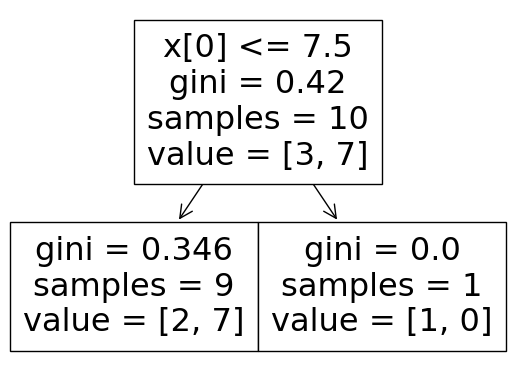

In [207]:
plot_tree(dt2)

<Axes: >

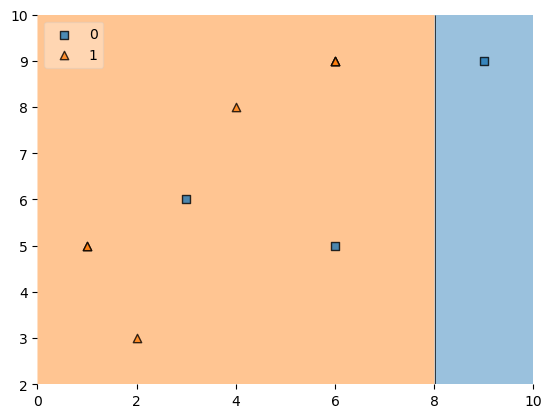

In [209]:
plot_decision_regions(X1, y1, clf=dt2, legend=2)

In [211]:
second_df['y_pred'] = dt2.predict(X1)

In [213]:
second_df

,X1,X2,label,weight,y_pred
5,6,9,1,0.1,1
0,1,5,1,0.1,1
5,6,9,1,0.1,1
5,6,9,1,0.1,1
1,2,3,1,0.1,1
6,6,5,0,0.1,1
8,9,9,0,0.1,0
0,1,5,1,0.1,1
3,4,8,1,0.1,1
2,3,6,0,0.1,1


This model made 2 mistakes, on rows 6 and 10.
<br>
REPEATING THE PROCESS

In [220]:
alpha2 = calculate_model_weight(0.2)
alpha2

0.6931471805599453

In [228]:
def update_row_weights(row, alpha=0.6931):
    if row['label'] == row['y_pred']:
        return row['weight'] * np.exp(-alpha)
    else:
        return row['weight'] * np.exp(alpha)

In [230]:
second_df['updated_weights'] = df.apply(update_row_weights, axis=1)

In [236]:
second_df['normalised_weights'] = second_df['updated_weights'] / second_df['updated_weights'].sum()

In [240]:
second_df['normalised_weights'].sum()

1.0

In [244]:
second_df['cumsum_upper'] = np.cumsum(second_df['normalised_weights'])

In [246]:
second_df['cumsum_lower'] = second_df['cumsum_upper'] - second_df['normalised_weights']

In [258]:
second_df[['X1','X2','label','weight','y_pred','updated_weights','cumsum_lower','cumsum_upper']]

,X1,X2,label,weight,y_pred,updated_weights,cumsum_lower,cumsum_upper
5,6,9,1,0.1,1,0.199991,0.000000,0.181814
0,1,5,1,0.1,1,0.050002,0.181814,0.227271
5,6,9,1,0.1,1,0.199991,0.227271,0.409085
5,6,9,1,0.1,1,0.199991,0.409085,0.590898
1,2,3,1,0.1,1,0.050002,0.590898,0.636356
6,6,5,0,0.1,1,0.050002,0.636356,0.681814
8,9,9,0,0.1,0,0.050002,0.681814,0.727271
0,1,5,1,0.1,1,0.050002,0.727271,0.772729
3,4,8,1,0.1,1,0.199991,0.772729,0.954542
2,3,6,0,0.1,1,0.050002,0.954542,1.000000


In [250]:
def create_new_dataset(df):
    indices = []
    for i in range(df.shape[0]):
        a = np.random.random()
        for index, row in df.iterrows():
            if row['cumsum_upper'] > a and row['cumsum_lower'] < a:
                indices.append(index)
    return indices

In [252]:
new_indexes = create_new_dataset(second_df)

In [254]:
new_indexes

[1, 5, 5, 8, 5, 5, 3, 2, 5, 5]

In [256]:
third_df = second_df.iloc[new_indexes, [0, 1, 2, 3]]
third_df

,X1,X2,label,weight
0,1,5,1,0.1
6,6,5,0,0.1
6,6,5,0,0.1
3,4,8,1,0.1
6,6,5,0,0.1
6,6,5,0,0.1
5,6,9,1,0.1
5,6,9,1,0.1
6,6,5,0,0.1
6,6,5,0,0.1


In [260]:
dt3 = DecisionTreeClassifier(max_depth=1)

In [262]:
X2 = third_df.iloc[:, 0:2].values
y2 = third_df.iloc[:, 2].values

In [264]:
dt3.fit(X2, y2)

DecisionTreeClassifier(max_depth=1)

<Axes: >

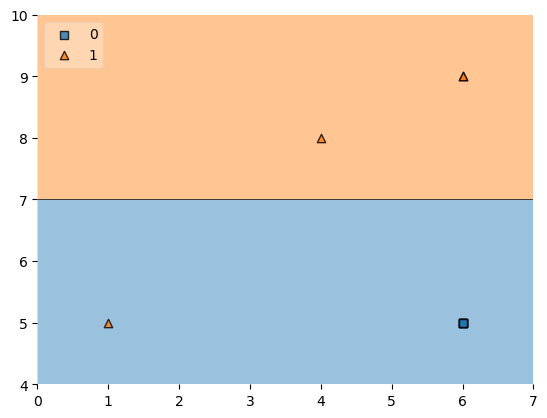

In [266]:
plot_decision_regions(X2, y2, clf=dt3, legend=2)

[Text(0.5, 0.75, 'x[1] <= 6.5\ngini = 0.48\nsamples = 10\nvalue = [6, 4]'),
 Text(0.25, 0.25, 'gini = 0.245\nsamples = 7\nvalue = [6, 1]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]')]

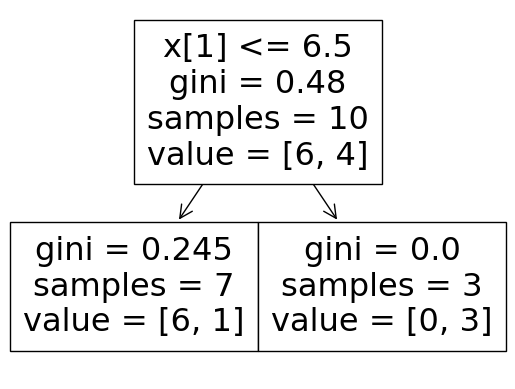

In [268]:
plot_tree(dt3)

In [272]:
third_df["y_pred"] = dt3.predict(X2)

In [274]:
third_df

,X1,X2,label,weight,y_pred
0,1,5,1,0.1,0
6,6,5,0,0.1,0
6,6,5,0,0.1,0
3,4,8,1,0.1,1
6,6,5,0,0.1,0
6,6,5,0,0.1,0
5,6,9,1,0.1,1
5,6,9,1,0.1,1
6,6,5,0,0.1,0
6,6,5,0,0.1,0


In [276]:
alpha3 = calculate_model_weight(0.1)
alpha3

1.0986122886681098

In [278]:
def update_row_weights(row, alpha=1.0986):
    if row['label'] == row['y_pred']:
        return row['weight'] * np.exp(-alpha)
    else:
        return row['weight'] * np.exp(alpha)

In [282]:
third_df['updated_weights'] = df.apply(update_row_weights, axis=1)

In [284]:
third_df

,X1,X2,label,weight,y_pred,updated_weights
0,1,5,1,0.1,0,0.033334
6,6,5,0,0.1,0,0.033334
6,6,5,0,0.1,0,0.033334
3,4,8,1,0.1,1,0.299996
6,6,5,0,0.1,0,0.033334
6,6,5,0,0.1,0,0.033334
5,6,9,1,0.1,1,0.299996
5,6,9,1,0.1,1,0.299996
6,6,5,0,0.1,0,0.033334
6,6,5,0,0.1,0,0.033334


In [286]:
third_df['normalised_weights'] = third_df['updated_weights'] / third_df['updated_weights'].sum()

In [288]:
third_df['cumsum_upper'] = np.cumsum(third_df['normalised_weights'])

In [290]:
third_df['cumsum_lower'] = third_df['cumsum_upper'] - third_df['normalised_weights']

In [292]:
third_df[['X1','X2','label','weight','y_pred','updated_weights','cumsum_lower','cumsum_upper']]

,X1,X2,label,weight,y_pred,updated_weights,cumsum_lower,cumsum_upper
0,1,5,1,0.1,0,0.033334,0.000000,0.029412
6,6,5,0,0.1,0,0.033334,0.029412,0.058825
6,6,5,0,0.1,0,0.033334,0.058825,0.088237
3,4,8,1,0.1,1,0.299996,0.088237,0.352942
6,6,5,0,0.1,0,0.033334,0.352942,0.382354
6,6,5,0,0.1,0,0.033334,0.382354,0.411766
5,6,9,1,0.1,1,0.299996,0.411766,0.676471
5,6,9,1,0.1,1,0.299996,0.676471,0.941175
6,6,5,0,0.1,0,0.033334,0.941175,0.970588
6,6,5,0,0.1,0,0.033334,0.970588,1.000000


In [294]:
def create_new_dataset(df):
    indices = []
    for i in range(df.shape[0]):
        a = np.random.random()
        for index, row in df.iterrows():
            if row['cumsum_upper'] > a and row['cumsum_lower'] < a:
                indices.append(index)
    return indices

In [296]:
final_indexes = create_new_dataset(third_df)

In [298]:
final_indexes

[3, 3, 3, 6, 3, 5, 3, 5, 6, 0]

In [300]:
fourth_df = df.iloc[final_indexes, [0, 1, 2, 3]]

In [302]:
fourth_df

,X1,X2,label,weight
3,4,8,1,0.1
3,4,8,1,0.1
3,4,8,1,0.1
6,6,5,0,0.1
3,4,8,1,0.1
5,6,9,1,0.1
3,4,8,1,0.1
5,6,9,1,0.1
6,6,5,0,0.1
0,1,5,1,0.1


In [304]:
dt4 = DecisionTreeClassifier(max_depth=1)

In [312]:
X3 = fourth_df.iloc[:, 0:2].values
y3 = fourth_df.iloc[:, 2].values

In [314]:
dt4.fit(X3, y3)

DecisionTreeClassifier(max_depth=1)

<Axes: >

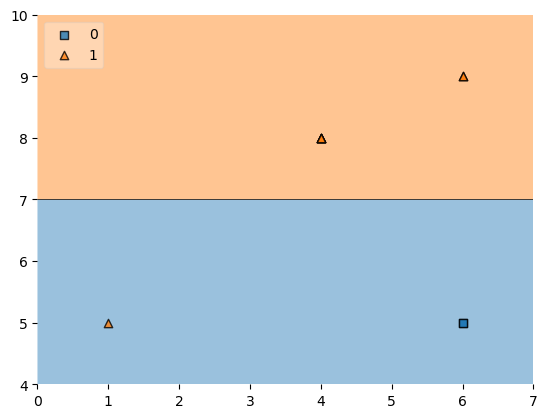

In [316]:
plot_decision_regions(X3, y3, clf=dt4, legend=2)

In [318]:
fourth_df["y_pred"] = dt4.predict(X3)

In [320]:
fourth_df

,X1,X2,label,weight,y_pred
3,4,8,1,0.1,1
3,4,8,1,0.1,1
3,4,8,1,0.1,1
6,6,5,0,0.1,0
3,4,8,1,0.1,1
5,6,9,1,0.1,1
3,4,8,1,0.1,1
5,6,9,1,0.1,1
6,6,5,0,0.1,0
0,1,5,1,0.1,0


In [359]:
alpha4 = calculate_model_weight(0.1)
alpha4

1.0986122886681098

#### Predictions

In [345]:
query = np.array([9, 9]).reshape(1, 2)
dt1.predict(query)

array([0], dtype=int64)

In [347]:
# query = np.array([9, 9]).reshape(1, 2)
# dt1.predict(query)

In [351]:
query = np.array([9, 9]).reshape(1, 2)
dt2.predict(query)

array([0], dtype=int64)

In [353]:
query = np.array([9, 9]).reshape(1, 2)
dt3.predict(query)

array([1], dtype=int64)

In [355]:
query = np.array([9, 9]).reshape(1, 2)
dt4.predict(query)

array([1], dtype=int64)

In [361]:
alpha1 * 1 + alpha2 * 1 + alpha3 * (-1) + alpha4 * (-1) 

-1.0804284665826724

In [365]:
np.sign(-1.08)

-1.0

The 